In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cairo

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn
import keras
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pickle
from keras.layers import Dense, GlobalAveragePooling2D
import sys
import numpy as np
import glob as glob
from keras import optimizers
import os
from mlxtend.plotting import plot_confusion_matrix
import random
from PIL import Image
from contextlib import redirect_stdout
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
image_width, image_height = 200, 200
epochs = 40
sample_per_epoch = 10000
number_of_validation_sample = 2000
batch_size = 8
test_size = 30
input_shape = (image_width, image_height, 3)
file_path_train = r"/home/ronaldsonbellande/Desktop/mobile_robotics/personal_repository/color_cube_detector_using_machine_learning/training_image_cubes"
file_path_validation = r"/home/ronaldsonbellande/Desktop/mobile_robotics/personal_repository/color_cube_detector_using_machine_learning/validation"
file_path_test = r"/home/ronaldsonbellande/Desktop/mobile_robotics/personal_repository/color_cube_detector_using_machine_learning/testing"

In [3]:
number_training_simple = 0
for read, directory, files in os.walk(file_path_train):
    for dir in directory:
        number_training_simple += len(glob.glob(os.path.join(read, dir + "/*")))
        
number_validation_simple = 0
for read, directory, files in os.walk(file_path_validation):
    for dir in directory:
        number_validation_simple += len(glob.glob(os.path.join(read, dir + "/*")))
        
number_testing_simple = 0
for read, directory, files in os.walk(file_path_test):
    for dir in directory:
        number_testing_simple += len(glob.glob(os.path.join(read, dir + "/*")))

In [4]:
print(number_testing_simple)
print(number_validation_simple)
print(number_training_simple)

9
9
39


In [5]:
model = Sequential()

model.add(Conv2D(32, 3, 3, padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, 3, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(loss='binary_crossentropy',
            optimizer = 'adam',
            metrics=['accuracy'])

In [6]:
model_summary = model.summary()
with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 67, 67, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0

In [7]:
training_data_image_classification = ImageDataGenerator(rescale = 1./255,
                                                        rotation_range = 20,
                                                        width_shift_range = 0.2,
                                                        height_shift_range = 0.2,
                                                        shear_range = 0.2,
                                                        zoom_range = 0.2,
                                                        fill_mode = 'nearest',
                                                        horizontal_flip = True)

validation_data_image_classification = ImageDataGenerator(rescale = 1./255,
                                                        rotation_range = 20,
                                                        width_shift_range = 0.2,
                                                        height_shift_range = 0.2,
                                                        shear_range = 0.2,
                                                        zoom_range = 0.2,
                                                        fill_mode = 'nearest',
                                                        horizontal_flip = True)

test_data_image_classification = ImageDataGenerator(rescale = 1./255,
                                                        rotation_range = 20,
                                                        width_shift_range = 0.2,
                                                        height_shift_range = 0.2,
                                                        shear_range = 0.2,
                                                        zoom_range = 0.2,
                                                        fill_mode = 'nearest',
                                                        horizontal_flip = True)

In [8]:
training_generator = training_data_image_classification.flow_from_directory(file_path_train,
    target_size=(image_width, image_height),
    batch_size=batch_size, class_mode="binary")

Found 39 images belonging to 3 classes.


In [9]:
validation_generator = validation_data_image_classification.flow_from_directory(file_path_validation,
    target_size=(image_width, image_height),
    batch_size=batch_size, class_mode="binary")

Found 9 images belonging to 3 classes.


In [10]:
test_generator = test_data_image_classification.flow_from_directory(file_path_test,
    target_size=(image_width, image_height),
    batch_size=batch_size, class_mode="binary")

Found 9 images belonging to 3 classes.


In [11]:
for data_batch, labels_batch in training_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (8, 200, 200, 3)
labels batch shape: (8,)


In [12]:
class_names = training_generator.class_indices
print(class_names)

{'green_cubes': 0, 'red_cubes': 1, 'yellow_cubes': 2}


In [13]:
 checkpoint = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4, verbose=1)

In [14]:
trained_model = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator.filenames)//training_generator.batch_size,
    initial_epoch=0,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames)//validation_generator.batch_size,
    callbacks=[checkpoint],
    shuffle = True, verbose=1)

# trained_model = model.fit(training_generator,
#                          steps_per_epoch = number_training_simple,
#                          epochs = epochs,
#                          validation_data = validation_generator,
#                          validation_steps = len(validation_generator.filenames)//validation_generator.batch_size)

Epoch 1/40
4/4 [==============================] - 9s 2s/step - loss: 0.6193 - accuracy: 0.3500 - val_loss: 0.3939 - val_accuracy: 0.3750
Epoch 2/40
4/4 [==============================] - 3s 689ms/step - loss: 0.0399 - accuracy: 0.3020 - val_loss: -0.4950 - val_accuracy: 0.2500
Epoch 3/40
4/4 [==============================] - 2s 636ms/step - loss: -0.4883 - accuracy: 0.3332 - val_loss: -0.1760 - val_accuracy: 0.3750
Epoch 4/40
4/4 [==============================] - 2s 668ms/step - loss: -0.4447 - accuracy: 0.3792 - val_loss: -3.4988 - val_accuracy: 0.3750
Epoch 5/40
4/4 [==============================] - 3s 725ms/step - loss: -1.0655 - accuracy: 0.2701 - val_loss: -5.2738 - val_accuracy: 0.3750
Epoch 6/40
4/4 [==============================] - 3s 645ms/step - loss: -4.8010 - accuracy: 0.4215 - val_loss: -7.7104 - val_accuracy: 0.2500
Epoch 7/40
4/4 [==============================] - 2s 626ms/step - loss: -4.0975 - accuracy: 0.3128 - val_loss: -13.2001 - val_accuracy: 0.2500
Epoch 8/40


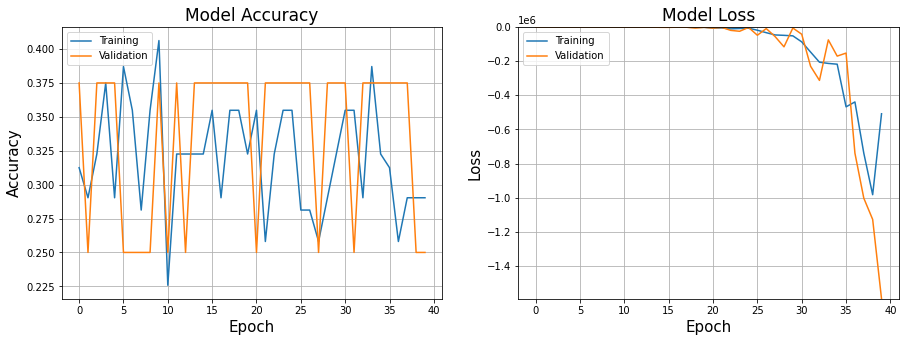

In [16]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']
ylim_pad = [0.01, 0.1]
plt.figure(figsize=(15, 5))
y1 = trained_model.history['accuracy']
y2 = trained_model.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)
plt.plot(y1)
plt.plot(y2)
plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
    
y1 = trained_model.history['loss']
y2 = trained_model.history['val_loss']
min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
plt.subplot(122)
plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()                      
plt.show()

In [17]:
print("results")
result  = model.evaluate(test_generator, steps=len(test_generator), verbose=2)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
2/2 - 0s - loss: -1.2484e+06 - accuracy: 0.3333
Loss     : -1248383.38  
Accuracy : 33.33%


In [18]:
classes = test_generator.class_indices
classes

{'green_cubes': 0, 'red_cubes': 1, 'yellow_cubes': 2}

In [19]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = y_pred.argmax(axis=-1)
# y_pred = y_pred.reshape(1,9)
# y_pred = y_pred[0]
y_true=test_generator.classes
print(y_pred)

2/2 [==============================] - 0s 20ms/step
[0 0 0 0 0 0 0 0 0]


/home/ronaldsonbellande/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 11.11%
Recall        : 33.33%
F1-Score      : 16.67%
------------------------------------------------------------------------------------------



---------fffff {'green_cubes': 0, 'red_cubes': 1, 'yellow_cubes': 2}


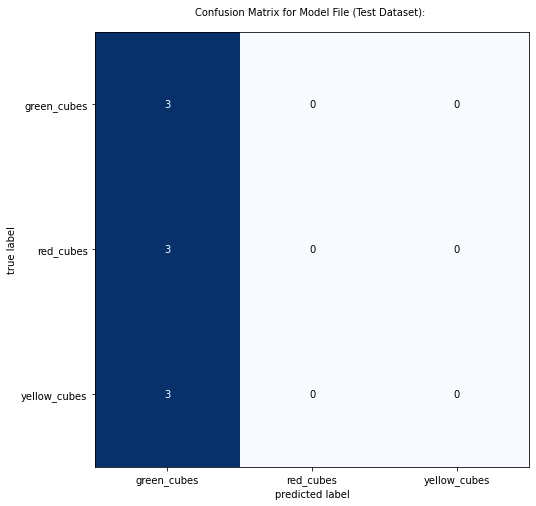




------------------------------------------------------------------------------------------
Report for Model File:  
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 green_cubes       0.33      1.00      0.50         3
   red_cubes       0.00      0.00      0.00         3
yellow_cubes       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9

------------------------------------------------------------------------------------------


/home/ronaldsonbellande/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronaldsonbellande/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronaldsonbellande/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/r

In [20]:
image_file_name = "/home/ronaldsonbellande/Desktop/mobile_robotics/personal_repository/color_cube_detector_using_machine_learning/"

file_path = 'CNN_cube_detector.h5'
title = file_path.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred, average="weighted") 
recall = recall_score(y_true, y_pred, average="weighted") 
f1 = f1_score(y_true, y_pred, average="weighted") 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

print("---------fffff", classes)
CM = confusion_matrix(y_true*10, y_pred*10)
fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(10,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=10)
plt.yticks(range(len(classes)), classes, fontsize=10)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=10)
fig.savefig(image_file_name, dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)